# Heart Failure Prediction Dataset
https://www.kaggle.com/fedesoriano/heart-failure-prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

heart = pd.read_csv('./data/heart.csv')
heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


1. Age: 나이(년)
2. Sex: 성별(M:남자, F:여자)
3. ChestPainType: 가슴 통증 종류(TA: Typical Angina(전형적 협심증), ATA: Atypical Angina(비전형적 흉통), NAP: Non-Anginal Pain(비협심증 흉통), ASY: Asymptomatic(무증상)) - [anginal pain (협심증)](https://blog.naver.com/swseungwoo/222197288576)
4. RestingBP: 안정 혈압(mmHg)
5. Cholesterol: 혈청 콜레스테롤(mm/dl)
6. FastingBS: 공복혈당(1: if FastingBS > 120 mg/dl, 0: otherwise)
7. RestingECG: 휴식 중 심전도(Normal: 보통, ST: ST-T파에 이상이 있음 (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: Estes' criteria에 의해 좌심실대비증이 의심되거나 확실한 경우)
8. MaxHR: 최대 심박수(60과 202 사이의 수치형 변수)
9. ExerciseAngina: 운동성 협심증(Y: Yes, N: No)
10. Oldpeak: oldpeak = ST [Numeric value measured in depression]  
11. ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]  
12. HeartDisease: output class [1: heart disease, 0: Normal]

## 예측

In [2]:
heart_drop = heart.drop(index=449) # 혈압이 0이었던 이상치 제외
heart_drop.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
obj_columns = [col for col in heart_drop.columns if heart_drop[col].dtype == 'object']
for col in obj_columns:
    print(f'{col}: {heart_drop[col].nunique()}개')

Sex: 2개
ChestPainType: 4개
RestingECG: 3개
ExerciseAngina: 2개
ST_Slope: 3개


값이 몇 개 되지 않으니 모두 label encoding 해보는 걸로

In [4]:
from sklearn.preprocessing import OrdinalEncoder

oe = OrdinalEncoder()
heart_drop[obj_columns] = oe.fit_transform(heart_drop[obj_columns])
heart_drop.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1.0,1.0,140,289,0,1.0,172,0.0,0.0,2.0,0
1,49,0.0,2.0,160,180,0,1.0,156,0.0,1.0,1.0,1
2,37,1.0,1.0,130,283,0,2.0,98,0.0,0.0,2.0,0
3,48,0.0,0.0,138,214,0,1.0,108,1.0,1.5,1.0,1
4,54,1.0,2.0,150,195,0,1.0,122,0.0,0.0,2.0,0


In [5]:
y = heart_drop.pop('HeartDisease')
X = heart_drop

X.shape, y.shape

((917, 11), (917,))

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.15, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=.2, random_state=0)

X_train.shape, X_val.shape, X_test.shape

((623, 11), (156, 11), (138, 11))

### 로지스틱 회귀
```python
LogisticRegression(
    penalty='l2',
    *,
    dual=False,
    tol=0.0001,
    C=1.0,
    fit_intercept=True,
    intercept_scaling=1,
    class_weight=None,
    random_state=None,
    solver='lbfgs',
    max_iter=100,
    multi_class='auto',
    verbose=0,
    warm_start=False,
    n_jobs=None,
    l1_ratio=None,
)
```

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

lr = LogisticRegression(fit_intercept=False)

params = {'tol':[0.001, 0.0001],
          'C':[0.1, 0.5, 1.0, 2.0]}

grid_lr = GridSearchCV(lr, param_grid=params, cv=5,
                       refit=True, return_train_score=True)

grid_lr.fit(X_train, y_train)

scores_df = pd.DataFrame(grid_lr.cv_results_)
scores_df.sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_tol,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
2,0.018949,0.000631,0.001197,0.000399,0.5,0.001,"{'C': 0.5, 'tol': 0.001}",0.824,0.856,0.784,...,0.834735,0.032001,1,0.861446,0.849398,0.855422,0.839679,0.841683,0.849526,0.008189
3,0.018949,0.000632,0.001795,0.000399,0.5,0.0001,"{'C': 0.5, 'tol': 0.0001}",0.824,0.856,0.784,...,0.834735,0.032001,1,0.861446,0.849398,0.855422,0.839679,0.841683,0.849526,0.008189
4,0.019149,0.000399,0.001596,0.000489,1.0,0.001,"{'C': 1.0, 'tol': 0.001}",0.824,0.856,0.784,...,0.834735,0.032001,1,0.861446,0.853414,0.851406,0.839679,0.845691,0.850327,0.007337
5,0.019947,0.000631,0.001596,0.000489,1.0,0.0001,"{'C': 1.0, 'tol': 0.0001}",0.824,0.856,0.784,...,0.834735,0.032001,1,0.861446,0.853414,0.851406,0.839679,0.845691,0.850327,0.007337
6,0.019149,0.000746,0.001596,0.000489,2.0,0.001,"{'C': 2.0, 'tol': 0.001}",0.824,0.848,0.776,...,0.833148,0.033783,5,0.863454,0.843373,0.851406,0.841683,0.845691,0.849122,0.007884


In [8]:
grid_lr.best_params_

{'C': 0.5, 'tol': 0.001}

In [9]:
grid_lr.best_score_

0.8347354838709677

In [10]:
grid_lr.best_estimator_.score(X_val, y_val)

0.8589743589743589

정확도: 0.8590, 정밀도: 0.8810, 재현율: 0.8605, f1 score: 0.8706, ROC_AUC score: 0.9251


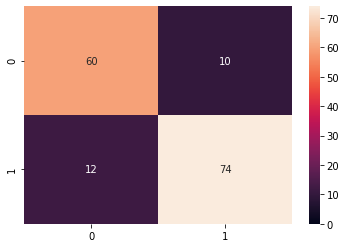

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score

def get_scores(model, X, y):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_proba)
    
    print(f'정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, f1 score: {f1:.4f}, ROC_AUC score: {auc:.4f}')
    
    con = confusion_matrix(y, y_pred)
    sns.heatmap(data=con, vmin=0, annot=True)
    plt.show()
    
get_scores(grid_lr.best_estimator_, X_val, y_val)

### 랜덤포레스트
```python
RandomForestClassifier(
    n_estimators=100,
    *,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None,
)
```

In [13]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=256)

params = {'max_depth':[None, 5, 7, 10, 15],
          'min_samples_split':[2, 3, 5],
          'min_samples_leaf':[1, 2, 4]}

grid_rf = GridSearchCV(rf_clf, param_grid=params, cv=5,
                       refit=True, return_train_score=True)
grid_rf.fit(X_train, y_train)

scores_df = pd.DataFrame(grid_rf.cv_results_)
scores_df.sort_values(by='rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
24,0.117281,0.000483,0.010172,0.000396,7,4,2,"{'max_depth': 7, 'min_samples_leaf': 4, 'min_s...",0.848,0.880,...,0.871665,0.023943,1,0.927711,0.923695,0.923695,0.917836,0.913828,0.921353,0.004907
25,0.119685,0.002534,0.012168,0.002488,7,4,3,"{'max_depth': 7, 'min_samples_leaf': 4, 'min_s...",0.848,0.880,...,0.871665,0.023943,1,0.927711,0.923695,0.923695,0.917836,0.913828,0.921353,0.004907
26,0.118084,0.001355,0.010170,0.000387,7,4,5,"{'max_depth': 7, 'min_samples_leaf': 4, 'min_s...",0.848,0.880,...,0.871665,0.023943,1,0.927711,0.923695,0.923695,0.917836,0.913828,0.921353,0.004907
19,0.119284,0.000799,0.010173,0.000399,7,1,3,"{'max_depth': 7, 'min_samples_leaf': 1, 'min_s...",0.856,0.872,...,0.870052,0.020126,4,0.967871,0.961847,0.961847,0.955912,0.953908,0.960277,0.004944
44,0.119281,0.000491,0.009973,0.000004,15,4,5,"{'max_depth': 15, 'min_samples_leaf': 4, 'min_...",0.840,0.872,...,0.868439,0.020941,5,0.923695,0.927711,0.923695,0.919840,0.917836,0.922555,0.003430


In [14]:
grid_rf.best_params_

{'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 2}

In [15]:
grid_rf.best_score_

0.8716645161290323

정확도: 0.9038, 정밀도: 0.8989, 재현율: 0.9302, f1 score: 0.9143, ROC_AUC score: 0.9522


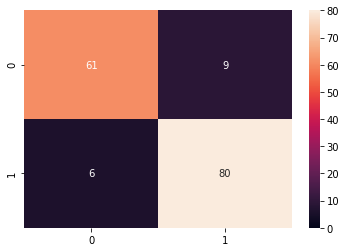

In [16]:
get_scores(grid_rf.best_estimator_, X_val, y_val)

### XGBoost
```
n_estimators : int
        Number of boosting rounds.
    use_label_encoder : bool
        (Deprecated) Use the label encoder from scikit-learn to encode the labels. For new
        code, we recommend that you set this parameter to False.

    max_depth : int
        Maximum tree depth for base learners.
    learning_rate : float
        Boosting learning rate (xgb's "eta")
    verbosity : int
        The degree of verbosity. Valid values are 0 (silent) - 3 (debug).
    objective : string or callable
        Specify the learning task and the corresponding learning objective or
        a custom objective function to be used (see note below).
    booster: string
        Specify which booster to use: gbtree, gblinear or dart.
    tree_method: string
        Specify which tree method to use.  Default to auto.  If this parameter
        is set to default, XGBoost will choose the most conservative option
        available.  It's recommended to study this option from parameters
        document.
    n_jobs : int
        Number of parallel threads used to run xgboost.  When used with other Scikit-Learn
        algorithms like grid search, you may choose which algorithm to parallelize and
        balance the threads.  Creating thread contention will significantly slow down both
        algorithms.
    gamma : float
        Minimum loss reduction required to make a further partition on a leaf
        node of the tree.
    min_child_weight : float
        Minimum sum of instance weight(hessian) needed in a child.
    max_delta_step : float
        Maximum delta step we allow each tree's weight estimation to be.
    subsample : float
        Subsample ratio of the training instance.
    colsample_bytree : float
        Subsample ratio of columns when constructing each tree.
    colsample_bylevel : float
        Subsample ratio of columns for each level.
    colsample_bynode : float
        Subsample ratio of columns for each split.
    reg_alpha : float (xgb's alpha)
        L1 regularization term on weights
    reg_lambda : float (xgb's lambda)
        L2 regularization term on weights
    scale_pos_weight : float
        Balancing of positive and negative weights.
    base_score:
        The initial prediction score of all instances, global bias.
    random_state : int
        Random number seed.
```

In [17]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(random_state=0)

params = {'max_depth':[None, 5, 7, 10, 15],
          'min_child_weight':[2, 3, 5],
          'colsample_bytree':[0.5, 0.8, 1.0]
          }

grid_xgb = GridSearchCV(xgb_clf, param_grid=params, cv=5,
                       refit=True, return_train_score=True)
grid_xgb.fit(X_train, y_train)

scores_df = pd.DataFrame(grid_xgb.cv_results_)
scores_df.sort_values(by='rank_test_score').head(5)

[14:33:32] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:33:32] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:33:32] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:33:32] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[14:33:34] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:33:34] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:33:34] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:33:34] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[14:33:36] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:33:36] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:33:36] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:33:36] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[14:33:38] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:33:38] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:33:38] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:33:38] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[14:33:39] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:33:40] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:33:40] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:33:40] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[14:33:41] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:33:41] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:33:41] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:33:41] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[14:33:43] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:33:43] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:33:43] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:33:43] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_max_depth,param_min_child_weight,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
1,0.046875,0.002601,0.002793,3.989220e-04,0.5,None,3,"{'colsample_bytree': 0.5, 'max_depth': None, '...",0.848,0.880,...,0.860374,0.019248,1,0.995984,0.997992,0.993976,0.997996,0.991984,0.995586,0.002338
5,0.041689,0.001596,0.002793,3.988505e-04,0.5,5,5,"{'colsample_bytree': 0.5, 'max_depth': 5, 'min...",0.848,0.856,...,0.857213,0.023073,2,0.965863,0.981928,0.969880,0.969940,0.965932,0.970708,0.005890
42,0.051662,0.002309,0.002992,1.907349e-07,1.0,15,2,"{'colsample_bytree': 1.0, 'max_depth': 15, 'mi...",0.856,0.856,...,0.857187,0.020917,3,0.997992,1.000000,1.000000,1.000000,1.000000,0.999598,0.000803
39,0.051462,0.001197,0.002793,3.991127e-04,1.0,10,2,"{'colsample_bytree': 1.0, 'max_depth': 10, 'mi...",0.856,0.856,...,0.857187,0.020917,3,0.997992,1.000000,1.000000,1.000000,1.000000,0.999598,0.000803
24,0.050066,0.001323,0.002992,9.536743e-08,0.8,10,2,"{'colsample_bytree': 0.8, 'max_depth': 10, 'mi...",0.856,0.856,...,0.857174,0.012498,5,0.997992,1.000000,1.000000,0.997996,1.000000,0.999198,0.000983


In [18]:
grid_xgb.best_params_

{'colsample_bytree': 0.5, 'max_depth': None, 'min_child_weight': 3}

In [19]:
grid_xgb.best_score_

0.8603741935483871

정확도: 0.8846, 정밀도: 0.8864, 재현율: 0.9070, f1 score: 0.8966, ROC_AUC score: 0.9279


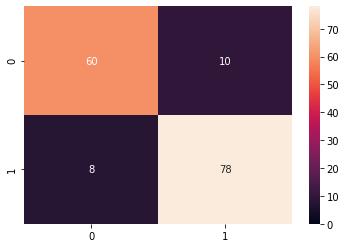

In [20]:
get_scores(grid_xgb.best_estimator_, X_val, y_val)

### LightGBM
```python
LGBMClassifier(
    boosting_type='gbdt',
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.1,
    n_estimators=100,
    subsample_for_bin=200000,
    objective=None,
    class_weight=None,
    min_split_gain=0.0,
    min_child_weight=0.001,
    min_child_samples=20,
    subsample=1.0,
    subsample_freq=0,
    colsample_bytree=1.0,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=None,
    n_jobs=-1,
    silent=True,
    importance_type='split',
    **kwargs,
)
```

In [21]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier()

params = {'max_depth':[-1, 5, 7, 10, 15],
          'colsample_bytree':[0.5, 0.8, 1.0]}

grid_lgb = GridSearchCV(lgbm, param_grid=params, cv=5,
                       refit=True, return_train_score=True)
grid_lgb.fit(X_train, y_train)

scores_df = pd.DataFrame(grid_lgb.cv_results_)
scores_df.sort_values(by='rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
8,0.028125,0.002706,0.002593,0.000489,0.8,10,"{'colsample_bytree': 0.8, 'max_depth': 10}",0.856,0.840,0.856,...,0.862013,0.018202,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
6,0.025133,0.002221,0.002593,0.000489,0.8,5,"{'colsample_bytree': 0.8, 'max_depth': 5}",0.848,0.856,0.848,...,0.860400,0.021664,2,0.989960,0.993976,0.989960,0.989980,0.985972,0.989969,0.002531
3,0.028923,0.004678,0.002194,0.000399,0.5,10,"{'colsample_bytree': 0.5, 'max_depth': 10}",0.840,0.864,0.824,...,0.858826,0.024746,3,0.997992,1.000000,0.997992,0.997996,0.993988,0.997594,0.001963
5,0.029521,0.003764,0.002792,0.000399,0.8,-1,"{'colsample_bytree': 0.8, 'max_depth': -1}",0.864,0.840,0.832,...,0.858813,0.020236,4,1.000000,1.000000,1.000000,1.000000,0.997996,0.999599,0.000802
9,0.030706,0.000394,0.002593,0.000489,0.8,15,"{'colsample_bytree': 0.8, 'max_depth': 15}",0.864,0.840,0.832,...,0.858813,0.020236,4,1.000000,1.000000,1.000000,1.000000,0.997996,0.999599,0.000802


In [22]:
grid_lgb.best_params_

{'colsample_bytree': 0.8, 'max_depth': 10}

In [23]:
grid_lgb.best_score_

0.8620129032258065

정확도: 0.8718, 정밀도: 0.8837, 재현율: 0.8837, f1 score: 0.8837, ROC_AUC score: 0.9282


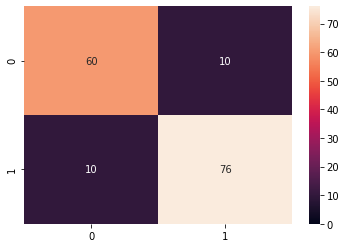

In [24]:
get_scores(grid_lgb.best_estimator_, X_val, y_val)

### 찾은 파라미터로 validation 데이터도 합친 뒤 학습, 평가

In [25]:
X_train_ = pd.concat([X_train, X_val])
X_train_.shape

(779, 11)

In [26]:
y_train_ = pd.concat([y_train, y_val])
y_train_.shape

(779,)

========== LogisticRegression ==========
정확도: 0.8333, 정밀도: 0.8841, 재현율: 0.8026, f1 score: 0.8414, ROC_AUC score: 0.9240


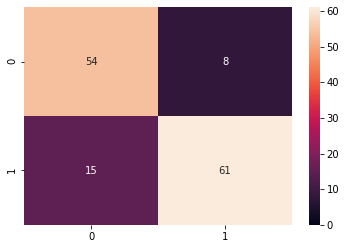

========== RandomForestClassifier ==========
정확도: 0.8623, 정밀도: 0.8800, 재현율: 0.8684, f1 score: 0.8742, ROC_AUC score: 0.9406


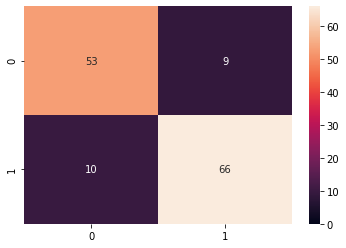

[14:35:13] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
========== XGBClassifier ==========
정확도: 0.8261, 정밀도: 0.8824, 재현율: 0.7895, f1 score: 0.8333, ROC_AUC score: 0.9242


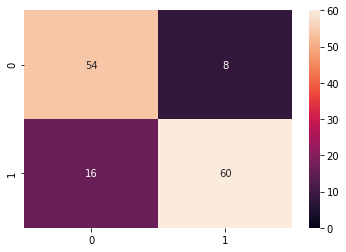

========== LGBMClassifier ==========
정확도: 0.8623, 정밀도: 0.9014, 재현율: 0.8421, f1 score: 0.8707, ROC_AUC score: 0.9342


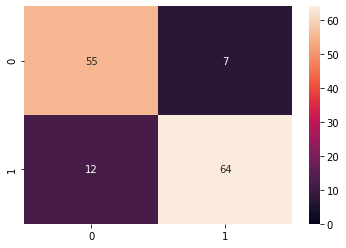

In [27]:
lr = LogisticRegression(fit_intercept=False, **grid_lr.best_params_)
rf = RandomForestClassifier(random_state=256, **grid_rf.best_params_)
xgb = XGBClassifier(**grid_xgb.best_params_)
lgb = LGBMClassifier(**grid_lgb.best_params_)

models = [lr, rf, xgb, lgb]
for model in models:
    model.fit(X_train_, y_train_)
    print('='*10, model.__class__.__name__, '='*10)
    get_scores(model, X_test, y_test)

## 분석

가장 성능이 좋은 랜덤포레스트를 분석

### feature_importances_

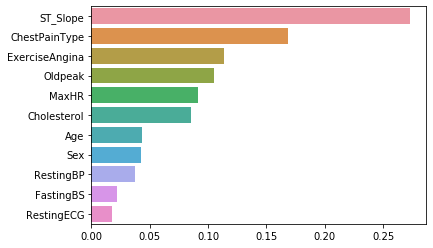

In [28]:
top20_features = pd.Series(rf.feature_importances_, index=X_train_.columns).sort_values(ascending=False)
sns.barplot(x=top20_features.values, y=top20_features.index)
plt.show()

### Permutataion Importance

In [29]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.1159 ± 0.0449,ST_Slope
0.0232 ± 0.0108,Cholesterol
0.0130 ± 0.0249,ChestPainType
0.0072 ± 0.0092,Sex
0.0058 ± 0.0192,Oldpeak
0.0058 ± 0.0058,RestingBP
0.0014 ± 0.0169,ExerciseAngina
-0.0014 ± 0.0108,MaxHR
-0.0043 ± 0.0071,FastingBS
-0.0058 ± 0.0108,Age


### Partial Plots

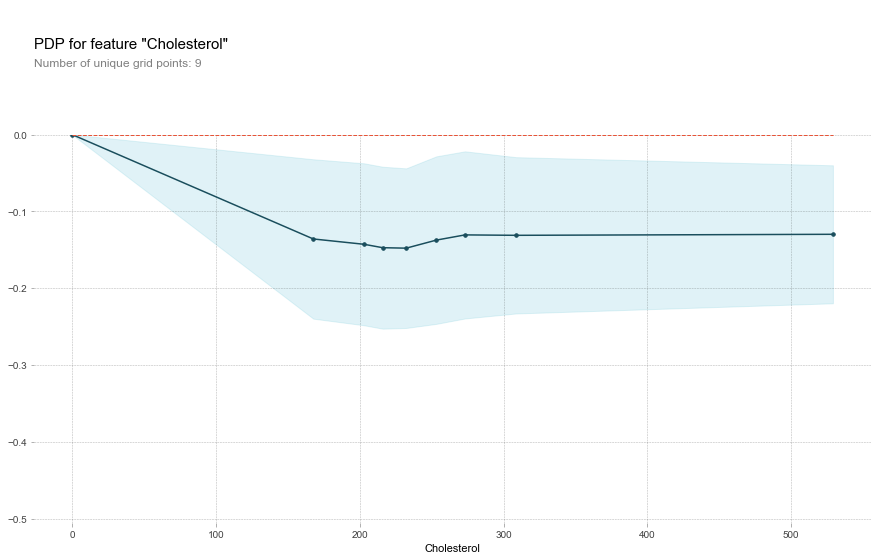

In [30]:
from pdpbox import pdp, get_dataset, info_plots

pdp_heart = pdp.pdp_isolate(model=rf, dataset=X_test, model_features=X_test.columns, feature='Cholesterol')
pdp.pdp_plot(pdp_heart, 'Cholesterol')
plt.show()

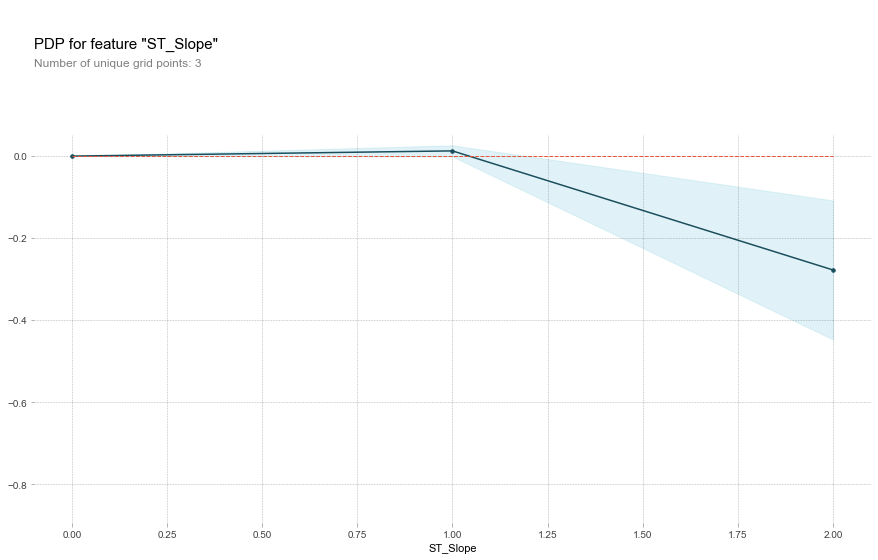

In [31]:
pdp_heart = pdp.pdp_isolate(model=rf, dataset=X_test, model_features=X_test.columns, feature='ST_Slope')
pdp.pdp_plot(pdp_heart, 'ST_Slope')
plt.show()

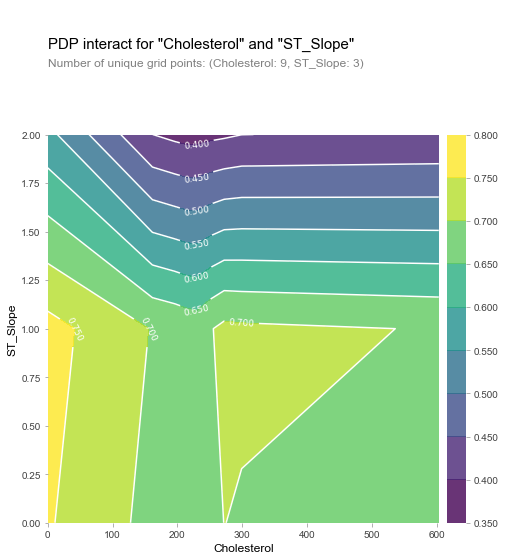

In [32]:
features_to_plot = ['Cholesterol', 'ST_Slope']
inter1  =  pdp.pdp_interact(model=rf, dataset=X_train, model_features=X_test.columns, features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()

### SHAP values

In [33]:
y_test.iloc[2]

1

In [34]:
import shap

data_for_prediction = X_test.iloc[2]


explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(data_for_prediction)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

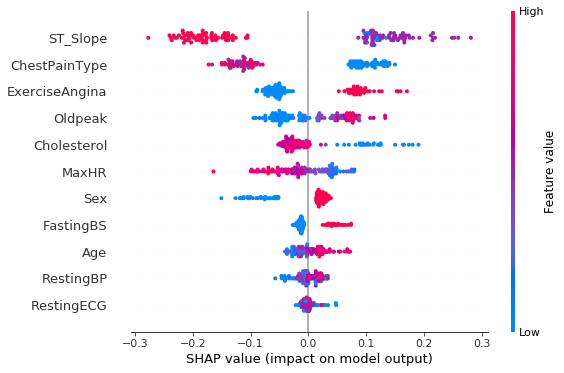

In [35]:
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test)

In [36]:
oe.categories_

[array(['F', 'M'], dtype=object),
 array(['ASY', 'ATA', 'NAP', 'TA'], dtype=object),
 array(['LVH', 'Normal', 'ST'], dtype=object),
 array(['N', 'Y'], dtype=object),
 array(['Down', 'Flat', 'Up'], dtype=object)]

In [37]:
obj_columns

['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

**ST_Slope를 봤을 때** Up(2)이면 음의 영향=심부전 위험도가 낮음, Flat 또는 Down(0, 1)이면 양의 영향=심부전 위험도가 높음  
**Sex를 봤을 때** 남자(1)면 양의 영향=심부전 위험도가 높음, 여자(0)면 음의 영향=심부전 위험도가 낮음

### DNN

In [38]:
from sklearn.preprocessing import MinMaxScaler

mscaler = MinMaxScaler()
mscaler.fit(X_train)
X_train_norm = mscaler.transform(X_train)
X_val_norm = mscaler.transform(X_val)

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(X_train_norm.shape[1], )))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                384       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 10,945
Trainable params: 10,945
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [42]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_accuracy',
                   mode='max',
                   patience=10,
                   verbose=1)

In [43]:
hist = model.fit(X_train_norm, y_train.values, epochs=100,
                 validation_data=(X_val_norm, y_val.values),
                 callbacks=[es])

Epoch 1/100
20/20 [==============================] - 1s 9ms/step - loss: 0.6238 - accuracy: 0.6629 - val_loss: 0.5233 - val_accuracy: 0.7564
Epoch 2/100
20/20 [==============================] - 0s 3ms/step - loss: 0.4773 - accuracy: 0.8250 - val_loss: 0.4136 - val_accuracy: 0.8397
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4018 - accuracy: 0.8475 - val_loss: 0.3710 - val_accuracy: 0.8397
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3878 - accuracy: 0.8395 - val_loss: 0.3584 - val_accuracy: 0.8654
Epoch 5/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3723 - accuracy: 0.8491 - val_loss: 0.3769 - val_accuracy: 0.8333
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3609 - accuracy: 0.8491 - val_loss: 0.3481 - val_accuracy: 0.8654
Epoch 7/100
20/20 [==============================] - 0s 3ms/step - loss: 0.3506 - accuracy: 0.8539 - val_loss: 0.3615 - val_accuracy: 0.8462
Epoch 8/100
2

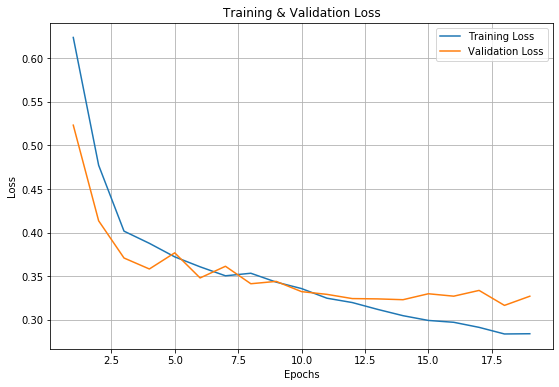

In [44]:
history = hist.history

epochs = range(1, len(history['loss']) + 1)

plt.figure(figsize=(9, 6))
plt.plot(epochs, history['loss'])
plt.plot(epochs, history['val_loss'])
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()

In [45]:
# 드랍아웃 추가
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(X_train_norm.shape[1], )))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

hist = model.fit(X_train_norm, y_train.values, epochs=100,
                 validation_data=(X_val_norm, y_val.values))

Epoch 1/100
20/20 [==============================] - 1s 10ms/step - loss: 0.6919 - accuracy: 0.5249 - val_loss: 0.6613 - val_accuracy: 0.5513
Epoch 2/100
20/20 [==============================] - 0s 6ms/step - loss: 0.6657 - accuracy: 0.6067 - val_loss: 0.6314 - val_accuracy: 0.6282
Epoch 3/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6375 - accuracy: 0.6212 - val_loss: 0.5831 - val_accuracy: 0.8141
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5771 - accuracy: 0.7303 - val_loss: 0.5088 - val_accuracy: 0.8013
Epoch 5/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5528 - accuracy: 0.7303 - val_loss: 0.4629 - val_accuracy: 0.8013
Epoch 6/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5367 - accuracy: 0.7400 - val_loss: 0.4331 - val_accuracy: 0.8013
Epoch 7/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5089 - accuracy: 0.7673 - val_loss: 0.4188 - val_accuracy: 0.8013
Epoch 8/100


Epoch 59/100
20/20 [==============================] - 0s 3ms/step - loss: 0.3724 - accuracy: 0.8523 - val_loss: 0.3229 - val_accuracy: 0.8846
Epoch 60/100
20/20 [==============================] - 0s 3ms/step - loss: 0.3749 - accuracy: 0.8539 - val_loss: 0.3245 - val_accuracy: 0.8782
Epoch 61/100
20/20 [==============================] - 0s 3ms/step - loss: 0.3446 - accuracy: 0.8716 - val_loss: 0.3285 - val_accuracy: 0.8782
Epoch 62/100
20/20 [==============================] - 0s 3ms/step - loss: 0.3760 - accuracy: 0.8475 - val_loss: 0.3254 - val_accuracy: 0.8782
Epoch 63/100
20/20 [==============================] - 0s 3ms/step - loss: 0.3599 - accuracy: 0.8604 - val_loss: 0.3248 - val_accuracy: 0.8782
Epoch 64/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3520 - accuracy: 0.8571 - val_loss: 0.3183 - val_accuracy: 0.8718
Epoch 65/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3723 - accuracy: 0.8427 - val_loss: 0.3168 - val_accuracy: 0.8910
Epoch 

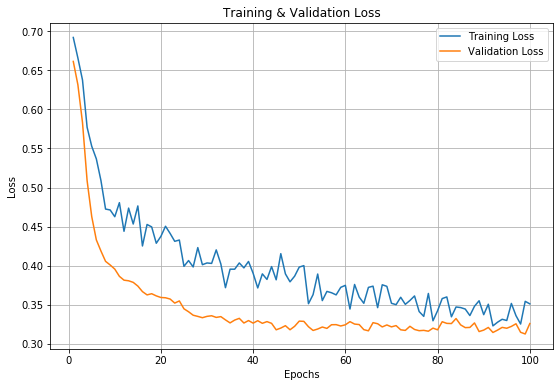

In [46]:
history = hist.history

epochs = range(1, len(history['loss']) + 1)

plt.figure(figsize=(9, 6))
plt.plot(epochs, history['loss'])
plt.plot(epochs, history['val_loss'])
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()

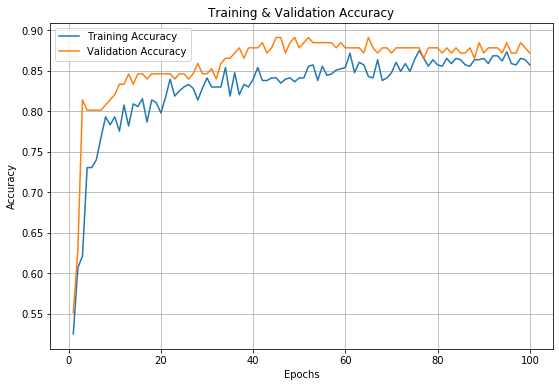

In [47]:
plt.figure(figsize=(9, 6))
plt.plot(epochs, history['accuracy'])
plt.plot(epochs, history['val_accuracy'])
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid()
plt.show()

In [48]:
# train+val

mscaler = MinMaxScaler()
mscaler.fit(X_train_)
X_train_norm_ = mscaler.transform(X_train_)
X_test_norm = mscaler.transform(X_test)

In [49]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(X_train_norm.shape[1], )))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

hist = model.fit(X_train_norm_, y_train_.values, epochs=200,
                 validation_data=(X_test_norm, y_test.values))

Epoch 1/200
25/25 [==============================] - 1s 9ms/step - loss: 0.6702 - accuracy: 0.5802 - val_loss: 0.6324 - val_accuracy: 0.6304
Epoch 2/200
25/25 [==============================] - 0s 5ms/step - loss: 0.6159 - accuracy: 0.6418 - val_loss: 0.5708 - val_accuracy: 0.7754
Epoch 3/200
25/25 [==============================] - 0s 4ms/step - loss: 0.5666 - accuracy: 0.7279 - val_loss: 0.5017 - val_accuracy: 0.8043
Epoch 4/200
25/25 [==============================] - 0s 3ms/step - loss: 0.5183 - accuracy: 0.7779 - val_loss: 0.4574 - val_accuracy: 0.8043
Epoch 5/200
25/25 [==============================] - 0s 3ms/step - loss: 0.4978 - accuracy: 0.7920 - val_loss: 0.4408 - val_accuracy: 0.7899
Epoch 6/200
25/25 [==============================] - 0s 3ms/step - loss: 0.4605 - accuracy: 0.8113 - val_loss: 0.4328 - val_accuracy: 0.8043
Epoch 7/200
25/25 [==============================] - 0s 3ms/step - loss: 0.4724 - accuracy: 0.7985 - val_loss: 0.4265 - val_accuracy: 0.8043
Epoch 8/200
2

Epoch 59/200
25/25 [==============================] - 0s 3ms/step - loss: 0.3421 - accuracy: 0.8691 - val_loss: 0.3515 - val_accuracy: 0.8551
Epoch 60/200
25/25 [==============================] - 0s 3ms/step - loss: 0.3468 - accuracy: 0.8678 - val_loss: 0.3497 - val_accuracy: 0.8551
Epoch 61/200
25/25 [==============================] - 0s 3ms/step - loss: 0.3287 - accuracy: 0.8652 - val_loss: 0.3522 - val_accuracy: 0.8333
Epoch 62/200
25/25 [==============================] - 0s 3ms/step - loss: 0.3358 - accuracy: 0.8626 - val_loss: 0.3484 - val_accuracy: 0.8406
Epoch 63/200
25/25 [==============================] - 0s 3ms/step - loss: 0.3454 - accuracy: 0.8678 - val_loss: 0.3515 - val_accuracy: 0.8333
Epoch 64/200
25/25 [==============================] - 0s 3ms/step - loss: 0.3297 - accuracy: 0.8652 - val_loss: 0.3413 - val_accuracy: 0.8551
Epoch 65/200
25/25 [==============================] - 0s 3ms/step - loss: 0.3348 - accuracy: 0.8652 - val_loss: 0.3404 - val_accuracy: 0.8551
Epoch 

25/25 [==============================] - 0s 3ms/step - loss: 0.3260 - accuracy: 0.8678 - val_loss: 0.3314 - val_accuracy: 0.8768
Epoch 117/200
25/25 [==============================] - 0s 4ms/step - loss: 0.3288 - accuracy: 0.8716 - val_loss: 0.3328 - val_accuracy: 0.8841
Epoch 118/200
25/25 [==============================] - 0s 4ms/step - loss: 0.3062 - accuracy: 0.8806 - val_loss: 0.3396 - val_accuracy: 0.8768
Epoch 119/200
25/25 [==============================] - 0s 4ms/step - loss: 0.3229 - accuracy: 0.8729 - val_loss: 0.3379 - val_accuracy: 0.8696
Epoch 120/200
25/25 [==============================] - 0s 3ms/step - loss: 0.3154 - accuracy: 0.8729 - val_loss: 0.3402 - val_accuracy: 0.8551
Epoch 121/200
25/25 [==============================] - 0s 4ms/step - loss: 0.3068 - accuracy: 0.8768 - val_loss: 0.3382 - val_accuracy: 0.8696
Epoch 122/200
25/25 [==============================] - 0s 4ms/step - loss: 0.2975 - accuracy: 0.8793 - val_loss: 0.3430 - val_accuracy: 0.8696
Epoch 123/200

25/25 [==============================] - 0s 3ms/step - loss: 0.2924 - accuracy: 0.8845 - val_loss: 0.3252 - val_accuracy: 0.8841
Epoch 174/200
25/25 [==============================] - 0s 3ms/step - loss: 0.3196 - accuracy: 0.8755 - val_loss: 0.3241 - val_accuracy: 0.8768
Epoch 175/200
25/25 [==============================] - 0s 3ms/step - loss: 0.2901 - accuracy: 0.8858 - val_loss: 0.3301 - val_accuracy: 0.8768
Epoch 176/200
25/25 [==============================] - 0s 3ms/step - loss: 0.2873 - accuracy: 0.8883 - val_loss: 0.3442 - val_accuracy: 0.8696
Epoch 177/200
25/25 [==============================] - 0s 3ms/step - loss: 0.2934 - accuracy: 0.8819 - val_loss: 0.3347 - val_accuracy: 0.8768
Epoch 178/200
25/25 [==============================] - 0s 4ms/step - loss: 0.2801 - accuracy: 0.8858 - val_loss: 0.3353 - val_accuracy: 0.8768
Epoch 179/200
25/25 [==============================] - 0s 4ms/step - loss: 0.2915 - accuracy: 0.8935 - val_loss: 0.3489 - val_accuracy: 0.8623
Epoch 180/200

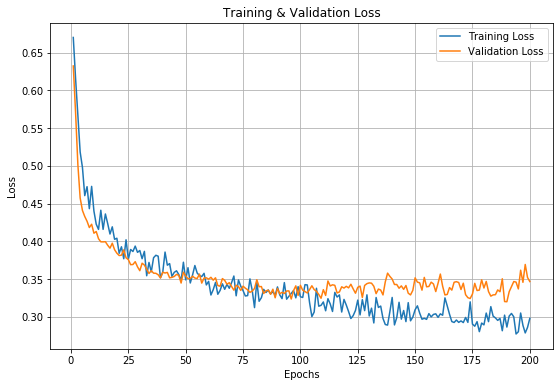

In [50]:
history = hist.history

epochs = range(1, len(history['loss']) + 1)

plt.figure(figsize=(9, 6))
plt.plot(epochs, history['loss'])
plt.plot(epochs, history['val_loss'])
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()

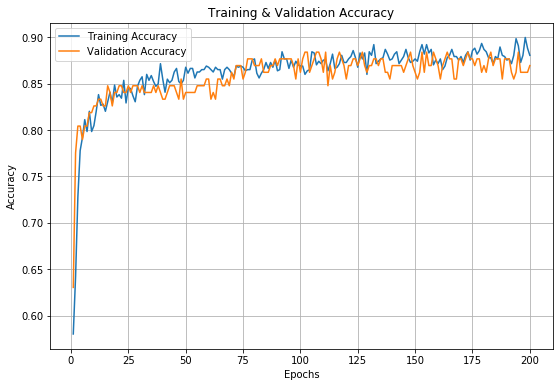

In [51]:
plt.figure(figsize=(9, 6))
plt.plot(epochs, history['accuracy'])
plt.plot(epochs, history['val_accuracy'])
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid()
plt.show()

In [52]:
model.evaluate(X_test_norm, y_test)

5/5 [==============================] - 0s 9ms/step - loss: 0.3466 - accuracy: 0.8696


[0.34656572341918945, 0.8695651888847351]

랜덤포레스트보다 정확도가 약간 더 높다.

In [53]:
pred = model.predict(X_test_norm)
pred[:5]

array([[0.12806621],
       [0.01653115],
       [0.86437136],
       [0.6847677 ],
       [0.0423068 ]], dtype=float32)

In [54]:
y_test[:5]

899    1
159    0
576    1
396    1
47     0
Name: HeartDisease, dtype: int64

In [55]:
y_pred = (pred > 0.5).astype(int)

정확도: 0.8696, 정밀도: 0.9028, 재현율: 0.8553, f1 score: 0.8784, ROC_AUC score: 0.9300


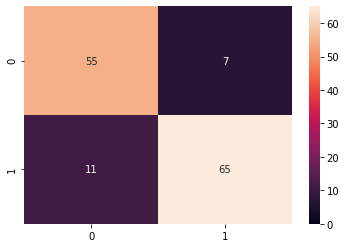

In [56]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, pred)

print(f'정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, f1 score: {f1:.4f}, ROC_AUC score: {auc:.4f}')

con = confusion_matrix(y_test, y_pred)
sns.heatmap(data=con, vmin=0, annot=True)
plt.show()

원핫인코딩 했을 때보다 정확도가 약간 떨어졌다. 그러나 엄청 큰 차이는 아닌 것처럼 보인다.

| Model              | Accuracy | Precision | Recall | F1     | AUC    |
|--------------------|----------|-----------|--------|--------|--------|
| RandomForest (OHE) | 0.8696   | 0.8919    | 0.8684 | 0.8800 | 0.9382 |
| DNN (OHE)          | 0.8768   | 0.9041    | 0.8684 | 0.8859 | 0.9200 |
| RandomForest (LE)  | 0.8623   | 0.8800    | 0.8684 | 0.8742 | 0.9406 |
| DNN (LE)           | 0.8696   | 0.9028    | 0.8553 | 0.8784 | 0.9300 |


심부전 증상을 찾기 위한 모델이라고 생각했을 때, 재현율이 중요한 지표이므로 재현율이 높은 모델을 선정하는 것이 제일 좋으며, 같은 재현율을 가진 모델 사이에서 정확도가 가장 높은 DNN(OHE)을 사용하는 것이 가장 좋아보인다.  
feature 중요도를 확인할 수 없는 점이 흠이라면 흠이지만 비슷한 성능을 가진 랜덤포레스트 분석 결과 ST_slope가 공통적으로 가장 큰 영향을 주는 것이 확인되었다.

다음 할 일 : 캐글 코드를 보면서 내가 한 것과 달리 어떻게 성능을 발전시켰는지 보고 따라하고 배우기